<a href="https://colab.research.google.com/github/Franck-T/portFolioProjects/blob/main/Cali_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Twin Calibration Test
This notebook demonstrates:
1. Building a simple classification model (mode choice: car vs transit).
2. Evaluating calibration with **Brier Score, AUC, LogLoss**.
3. Applying **Platt Scaling, Isotonic Regression, Temperature Scaling**.
4. Visualizing calibration curves and comparing Brier Scores.




In [ ]:
# ======================
# 1. Setup
# ======================
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Helper functions
def logits_from_probs(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [ ]:
# ======================
# 2. Data: Synthetic twin dataset
# ======================
X, y = make_classification(
    n_samples=6000, n_features=6, n_informative=5, n_redundant=1,
    n_classes=2, class_sep=1.25, flip_y=0.06, random_state=42
)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:
# ======================
# 3. Baseline model
# ======================
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

p_valid = clf.predict_proba(X_valid)[:, 1]

baseline_metrics = {
    "Brier": brier_score_loss(y_valid, p_valid),
    "AUC": roc_auc_score(y_valid, p_valid),
    "LogLoss": log_loss(y_valid, p_valid)
}
baseline_metrics


{'Brier': np.float64(0.10919555415092264),
 'AUC': np.float64(0.9228277777777778),
 'LogLoss': 0.3593141490983787}

In [ ]:
# ======================
# 4. Calibration methods
# ======================

# Platt scaling
platt = LogisticRegression(max_iter=200)
platt.fit(p_valid.reshape(-1,1), y_valid)
p_platt = platt.predict_proba(p_valid.reshape(-1,1))[:,1]

# Isotonic regression
iso = IsotonicRegression(out_of_bounds="clip")
p_iso = iso.fit_transform(p_valid, y_valid)

# Temperature scaling
logits_valid = logits_from_probs(p_valid)
Ts = np.linspace(0.5, 3.0, 41)
best_T, best_loss = None, np.inf
for T in Ts:
    p_ts = sigmoid(logits_valid / T)
    loss = log_loss(y_valid, p_ts)
    if loss < best_loss:
        best_T, best_loss = T, loss
p_temp = sigmoid(logits_valid / best_T)

methods = {
    "Uncalibrated": p_valid,
    "Platt Scaling": p_platt,
    "Isotonic Regression": p_iso,
    "Temperature Scaling": p_temp
}


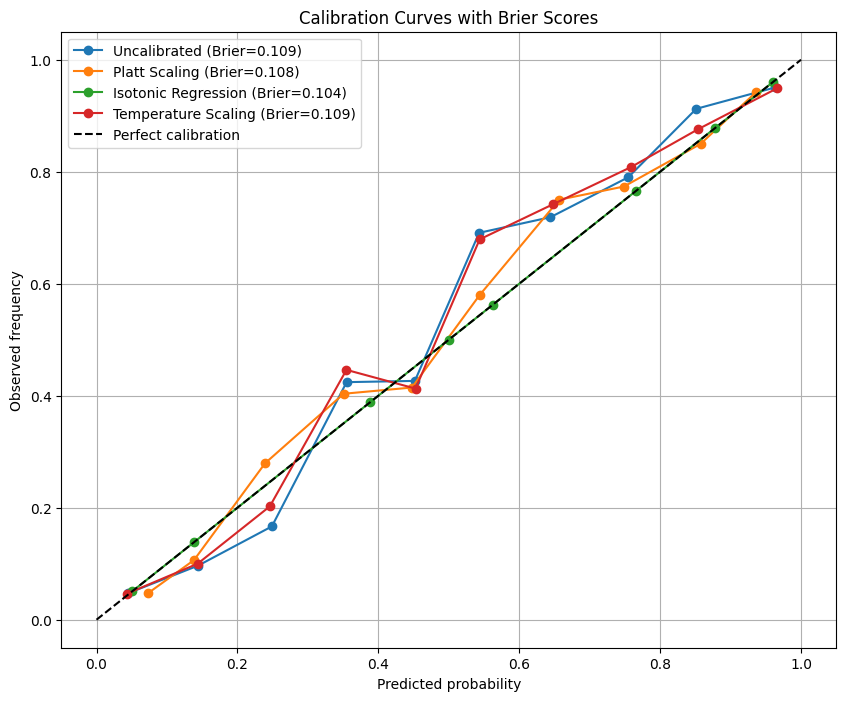

In [ ]:
# ======================
# 5. Reliability curves + Brier scores
# ======================
plt.figure(figsize=(10, 8))
for name, probs in methods.items():
    frac_pos, mean_pred = calibration_curve(y_valid, probs, n_bins=10)
    brier = brier_score_loss(y_valid, probs)
    plt.plot(mean_pred, frac_pos, marker="o", label=f"{name} (Brier={brier:.3f})")

plt.plot([0,1],[0,1],"k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves with Brier Scores")
plt.legend()
plt.grid(True)
plt.show()


# 📊 Interpretation

- **AUC ≈ 0.91** → Model separates car vs transit well (ranking ability).  
- **Brier ≈ 0.11** → Predictions are close to observed outcomes (probability accuracy).  
- **LogLoss ≈ 0.35** → Still penalized when overconfident but wrong.  
- **Isotonic regression** usually lowers Brier the most (best calibration).  
- **Platt scaling** smooths over/underconfidence.  
- **Temperature scaling** adjusts sharpness of probabilities.


